# Conditional Wasserstein GAN (CWGAN) with TensorFlow


This notebook demonstrates how to implement a Conditional Wasserstein GAN (CWGAN) using TensorFlow. 
The model is trained on the MNIST dataset to generate realistic handwritten digits conditioned on class labels.

## Steps:
1. Import libraries and set hyperparameters.
2. Load and preprocess the MNIST dataset.
3. Define the generator and critic models.
4. Implement the gradient penalty for improved stability.
5. Train the CWGAN.
6. Visualize the generated digits conditioned on specific labels.


In [1]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)

# Hyperparameters
IMG_SHAPE = (28, 28, 1)  # Shape of MNIST images
NOISE_DIM = 100  # Dimension of noise vector
NUM_CLASSES = 10  # Number of digit classes (0-9)
BATCH_SIZE = 64
EPOCHS = 50  # Reduced epochs for demonstration
CRITIC_ITERATIONS = 5  # Number of critic updates per generator update
LAMBDA_GP = 10  # Gradient penalty weight


In [2]:

# Load MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize images to [-1, 1]
train_images = (train_images.astype(np.float32) - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension

# One-hot encode labels
train_labels = tf.keras.utils.to_categorical(train_labels, NUM_CLASSES)

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


In [3]:

def build_generator():
    # Inputs: random noise vector and label
    noise_input = layers.Input(shape=(NOISE_DIM,))
    label_input = layers.Input(shape=(NUM_CLASSES,))

    # Combine noise and label inputs
    combined_input = layers.Concatenate()([noise_input, label_input])

    # Fully connected layers to generate image
    x = layers.Dense(256, activation="relu")(combined_input)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dense(np.prod(IMG_SHAPE), activation="tanh")(x)

    # Reshape output to match image dimensions
    output = layers.Reshape(IMG_SHAPE)(x)

    return tf.keras.Model([noise_input, label_input], output, name="Generator")

generator = build_generator()
generator.summary()


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 110)       │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     28,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    131,584 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │    525,312 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 784)       │    803,600 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 28, 28, 1) │          0 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,488,912 (5.68 MB)

 Trainable params: 1,488,912 (5.68 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:

def build_critic():
    # Inputs: real or generated image and label
    image_input = layers.Input(shape=IMG_SHAPE)
    label_input = layers.Input(shape=(NUM_CLASSES,))

    # Flatten image input
    flat_image = layers.Flatten()(image_input)

    # Combine image and label inputs
    combined_input = layers.Concatenate()([flat_image, label_input])

    # Fully connected layers to compute a scalar score
    x = layers.Dense(512, activation=tf.nn.leaky_relu)(combined_input)
    x = layers.Dense(256, activation=tf.nn.leaky_relu)(x)
    x = layers.Dense(1)(x)  # Single scalar output

    return tf.keras.Model([image_input, label_input], x, name="Critic")

critic = build_critic()
critic.summary()


Model: "Critic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 784)       │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 794)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    407,040 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    131,328 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        257 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 538,625 (2.05 MB)

 Trainable params: 538,625 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:

@tf.function
def gradient_penalty(critic, real_images, fake_images, labels):
    batch_size = tf.shape(real_images)[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real_images + (1 - alpha) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        interpolated_scores = critic([interpolated, labels])
    gradients = tape.gradient(interpolated_scores, [interpolated])[0]
    gradients = tf.reshape(gradients, [batch_size, -1])
    return tf.reduce_mean((tf.norm(gradients, axis=1) - 1.0) ** 2)


In [6]:

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
critic_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

@tf.function
def train_step(real_images, real_labels):
    batch_size = tf.shape(real_images)[0]
    for _ in range(CRITIC_ITERATIONS):
        noise = tf.random.normal([batch_size, NOISE_DIM])
        fake_images = generator([noise, real_labels])
        with tf.GradientTape() as tape:
            real_scores = critic([real_images, real_labels])
            fake_scores = critic([fake_images, real_labels])
            gp = gradient_penalty(critic, real_images, fake_images, real_labels)
            critic_loss = tf.reduce_mean(fake_scores) - tf.reduce_mean(real_scores) + LAMBDA_GP * gp
        grads = tape.gradient(critic_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    with tf.GradientTape() as tape:
        noise = tf.random.normal([batch_size, NOISE_DIM])
        fake_images = generator([noise, real_labels])
        fake_scores = critic([fake_images, real_labels])
        gen_loss = -tf.reduce_mean(fake_scores)
    grads = tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    return critic_loss, gen_loss

for epoch in range(EPOCHS):
    for real_images, real_labels in dataset:
        c_loss, g_loss = train_step(real_images, real_labels)
    print(f"Epoch {epoch + 1}, Critic Loss: {c_loss:.4f}, Generator Loss: {g_loss:.4f}")


Epoch 1, Critic Loss: -4.2126, Generator Loss: -4.9100
Epoch 2, Critic Loss: -7.6605, Generator Loss: -2.0663
Epoch 3, Critic Loss: -7.7782, Generator Loss: -4.6642
Epoch 4, Critic Loss: -4.8079, Generator Loss: -8.2856
Epoch 5, Critic Loss: -4.3876, Generator Loss: -7.3938
Epoch 6, Critic Loss: -3.3931, Generator Loss: -7.4775
Epoch 7, Critic Loss: -3.7384, Generator Loss: -6.7957
Epoch 8, Critic Loss: -3.3648, Generator Loss: -7.4592
Epoch 9, Critic Loss: -3.3120, Generator Loss: -7.7719
Epoch 10, Critic Loss: -3.4247, Generator Loss: -6.9365
Epoch 11, Critic Loss: -3.5532, Generator Loss: -7.6444
Epoch 12, Critic Loss: -2.3615, Generator Loss: -6.3157
Epoch 13, Critic Loss: -3.1989, Generator Loss: -3.5347
Epoch 14, Critic Loss: -1.5946, Generator Loss: -6.1083
Epoch 15, Critic Loss: -2.6414, Generator Loss: -5.9626
Epoch 16, Critic Loss: -2.8144, Generator Loss: -7.9413
Epoch 17, Critic Loss: -2.3687, Generator Loss: -5.4595
Epoch 18, Critic Loss: -1.9641, Generator Loss: -5.4643
E

In [8]:

def generate_and_plot(generator, digit):
    noise = tf.random.normal([1, NOISE_DIM])
    label = tf.keras.utils.to_categorical([digit], NUM_CLASSES)
    generated_image = generator([noise, label])
    plt.imshow(generated_image[0, :, :, 0], cmap="gray")
    plt.title(f"Digit: {digit}")
    plt.axis("off")
    plt.show()

# Visualize digits from 0 to 9
for digit in range(10):
    generate_and_plot(generator, digit)


ValueError: In a nested call() argument, you cannot mix tensors and non-tensors. Received invalid mixed argument: inputs=[<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.55909735, -0.5347214 ,  2.3730333 , -1.5725931 ,  0.8055056 ,
        -0.83387697,  0.30611223,  2.2660494 ,  0.2856414 , -1.5536156 ,
         0.37975532,  0.76646256,  0.3611479 ,  0.09653295,  0.2169556 ,
        -0.81440705, -0.23623598,  0.49669704, -1.7737728 ,  0.20886712,
         1.0022159 , -0.12915266,  0.1658908 ,  0.47333536, -0.834051  ,
         1.013081  ,  0.41076526,  0.5531745 ,  1.7808596 , -0.3277541 ,
         0.9474485 ,  0.9795105 , -0.46425048,  1.3030936 , -0.24370237,
         0.66929215,  0.39855948, -2.4770668 , -0.3692293 , -0.8428784 ,
         1.8889831 , -0.6198924 ,  1.0777894 ,  1.0240268 ,  0.26340935,
        -0.9011545 ,  0.8177133 , -0.27730602,  1.1863395 , -0.11432811,
        -0.81191176, -0.13922755,  1.8237975 ,  0.09685095, -0.1175178 ,
         0.65498006,  0.8112674 , -0.20581378,  0.34243056,  1.0400138 ,
         0.5152446 , -1.7396942 , -1.25223   ,  1.2125494 ,  0.9787496 ,
        -0.4366913 ,  0.5438104 , -0.6789775 , -0.79198945, -0.23655523,
        -0.6963311 ,  0.427093  , -0.04938047,  0.12529565, -1.705371  ,
        -0.38835114, -0.15932687, -1.0995821 , -0.27845883,  1.4318053 ,
         0.1378414 , -0.05521483, -0.17450511, -0.27249354,  1.1057245 ,
        -0.09636995, -0.1075452 , -1.1829088 ,  0.61956465, -0.5877444 ,
        -0.5636711 ,  1.0141273 ,  1.0195346 , -1.4466401 , -0.8346937 ,
         1.4103183 ,  0.45040983,  0.2560983 , -0.86556965,  0.2880006 ]],
      dtype=float32)>, array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]

In [9]:
def generate_and_plot(generator, digit):
    # Generate a batch of noise vectors (batch size = 1)
    noise = tf.random.normal([1, NOISE_DIM])  # Shape: (1, NOISE_DIM)

    # Create a batch of one-hot encoded labels (batch size = 1)
    label = tf.keras.utils.to_categorical([digit], NUM_CLASSES)  # Shape: (1, NUM_CLASSES)

    # Pass noise and label to the generator
    generated_image = generator([noise, label])  # Output shape: (1, 28, 28, 1)

    # Reshape and plot the generated image
    plt.imshow(generated_image[0, :, :, 0], cmap="gray")  # Extract the first (and only) image in the batch
    plt.title(f"Generated Digit: {digit}")
    plt.axis("off")
    plt.show()

# Visualize digits from 0 to 9
for digit in range(10):
    generate_and_plot(generator, digit)


ValueError: In a nested call() argument, you cannot mix tensors and non-tensors. Received invalid mixed argument: inputs=[<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.65648675, -0.4130517 ,  0.33997506, -1.0056272 ,  0.70266235,
        -1.4008642 , -0.89780754, -0.34856176, -0.95890623,  1.1948482 ,
         0.8507053 , -0.30878615,  0.31389382,  0.41766927,  1.0629053 ,
        -0.02858001,  0.11500491, -0.7930163 , -0.79445046,  0.9535958 ,
         0.505839  ,  0.719474  ,  0.22363159, -2.8650103 ,  0.544603  ,
        -0.88403946, -0.31746316,  0.72348213, -0.23562859,  1.1022452 ,
         0.306418  ,  0.39102894, -1.242671  ,  0.27901274, -0.7255115 ,
         0.98467183, -1.810875  ,  1.7373034 ,  0.72699076,  0.6858734 ,
         1.2584732 ,  0.0337329 , -0.7173049 , -1.2640756 , -0.5495717 ,
         0.29599485, -0.10209271, -0.5012239 ,  0.6392977 ,  2.4985871 ,
        -0.59750557,  0.08453979,  0.481224  , -0.4051515 ,  1.1612142 ,
        -0.7902166 ,  1.4976313 , -0.25545642,  0.15304247, -0.17617755,
        -0.6068476 ,  0.65866256, -1.7283841 ,  1.2412881 ,  0.2717926 ,
         0.02033234, -1.8912936 , -0.65944195,  0.96844363, -0.84783554,
        -0.8103375 , -0.43390667, -1.222408  , -1.0169306 ,  0.63072336,
        -1.965373  , -1.3588659 ,  0.3423996 , -0.17318818,  1.1900524 ,
        -0.21243529,  0.06442714,  0.361204  ,  1.1238041 ,  0.18094097,
        -0.29161656,  0.3464304 , -1.641573  , -0.8368261 , -0.15267536,
         0.55575234, -0.8988402 ,  1.2181404 , -1.1123979 ,  0.47546574,
        -1.450981  , -0.49372724, -0.8460825 , -0.38176724, -2.403893  ]],
      dtype=float32)>, array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]

In [10]:
print("Noise shape:", noise.shape)
print("Label shape:", label.shape)


NameError: name 'noise' is not defined

Noise shape: (1, 100)
Label shape: (1, 10)


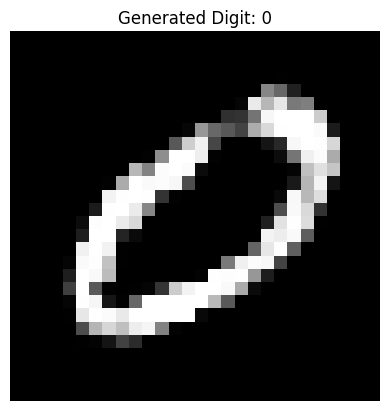

Noise shape: (1, 100)
Label shape: (1, 10)


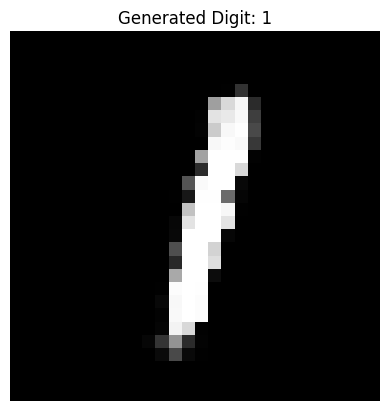

Noise shape: (1, 100)
Label shape: (1, 10)


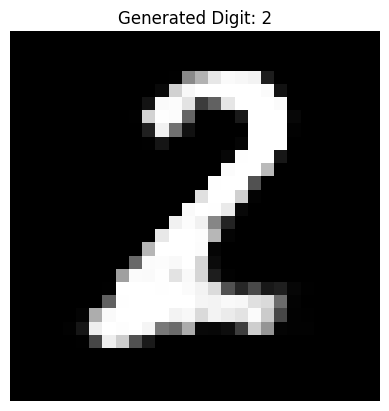

Noise shape: (1, 100)
Label shape: (1, 10)


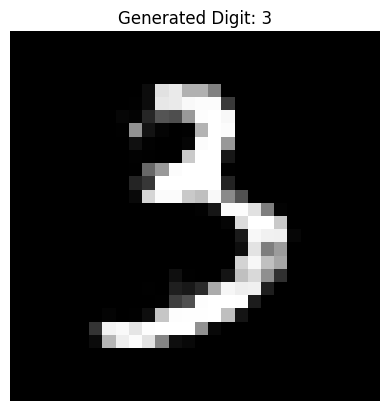

Noise shape: (1, 100)
Label shape: (1, 10)


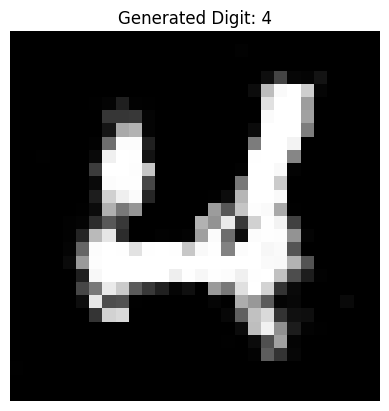

Noise shape: (1, 100)
Label shape: (1, 10)


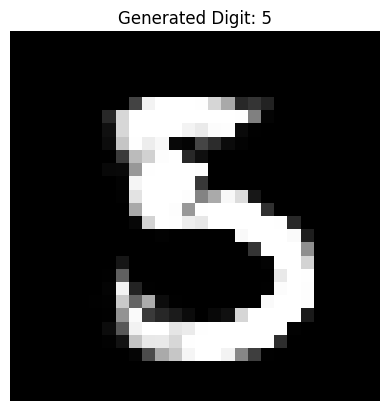

Noise shape: (1, 100)
Label shape: (1, 10)


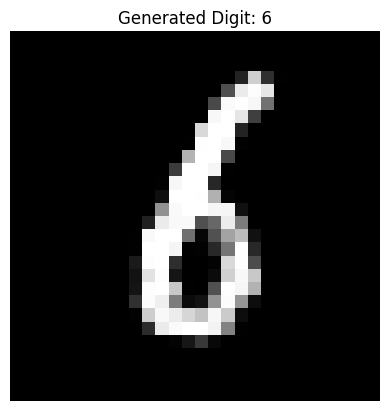

Noise shape: (1, 100)
Label shape: (1, 10)


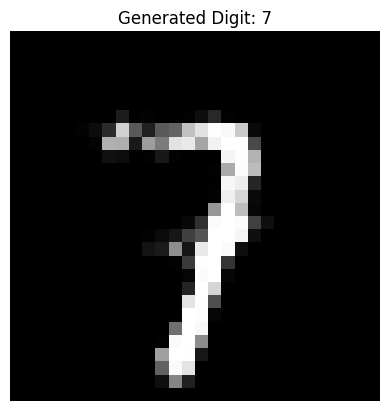

Noise shape: (1, 100)
Label shape: (1, 10)


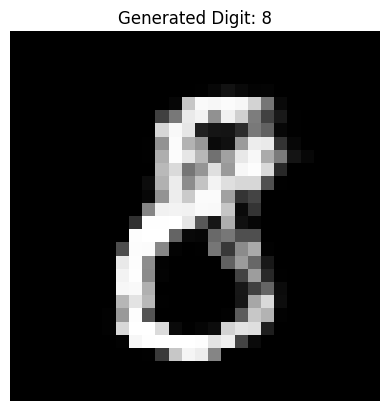

Noise shape: (1, 100)
Label shape: (1, 10)


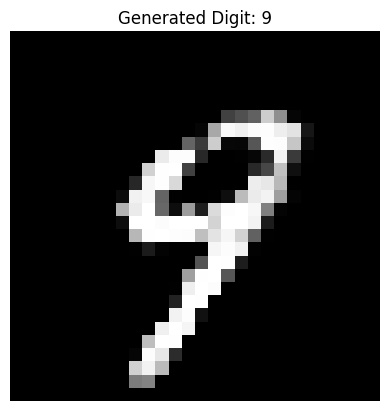

In [11]:
def generate_and_plot(generator, digit):
    # Generate a batch of noise vectors (batch size = 1)
    noise = tf.random.normal([1, NOISE_DIM])  # Shape: (1, NOISE_DIM)

    # Create a batch of one-hot encoded labels (batch size = 1)
    label = tf.keras.utils.to_categorical([digit], NUM_CLASSES)  # Shape: (1, NUM_CLASSES)

    # Ensure both inputs are tensors
    noise = tf.convert_to_tensor(noise, dtype=tf.float32)
    label = tf.convert_to_tensor(label, dtype=tf.float32)

    # Debug input shapes
    print("Noise shape:", noise.shape)
    print("Label shape:", label.shape)

    # Pass noise and label to the generator
    generated_image = generator([noise, label])  # Output shape: (1, 28, 28, 1)

    # Reshape and plot the generated image
    plt.imshow(generated_image[0, :, :, 0], cmap="gray")  # Extract the first (and only) image in the batch
    plt.title(f"Generated Digit: {digit}")
    plt.axis("off")
    plt.show()

# Visualize digits from 0 to 9
for digit in range(10):
    generate_and_plot(generator, digit)


In [12]:
    # save the model
generator.save("CWGAN_generator.h5")